This tutorial demostrates Pointer Networks with readable code.

In [1]:
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

USE_CUDA = False

In [2]:
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Generating dataset for sorting task</h3>

In [3]:
class SortDataset(Dataset):
    
    def __init__(self, data_len, num_samples, random_seed=111):
        super(SortDataset, self).__init__()
        torch.manual_seed(random_seed)

        self.data_set = []
        for _ in tqdm(range(num_samples)):
            x = x = torch.randperm(data_len)
            # x = x = torch.ones(data_len, dtype=torch.int64) # a modification to understand embedding and encoder
            self.data_set.append(x)

        self.size = len(self.data_set)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.data_set[idx]

In [4]:
train_size = 5000
val_size = 500

In [5]:
train_dataset = SortDataset(10, train_size)
val_dataset   = SortDataset(10, val_size)

100%|██████████| 500/500 [00:00<00:00, 83355.94it/s]


In [6]:
j = 0
for i in train_dataset:
    print(i)
    j += 1
    if j == 5:
        break

tensor([0, 2, 6, 1, 8, 7, 5, 4, 3, 9])
tensor([4, 1, 9, 5, 2, 0, 8, 6, 7, 3])
tensor([6, 1, 8, 7, 9, 0, 5, 2, 3, 4])
tensor([6, 4, 0, 7, 5, 1, 9, 2, 8, 3])
tensor([5, 7, 0, 6, 4, 3, 1, 8, 9, 2])


<h3>Attention mechanism</h3>
<p>
Using two types of attention mechanism: "Dot" and "Bahdanau" . More details in <a href="http://aclweb.org/anthology/D15-1166">Effective Approaches to Attention-based Neural Machine Translation</a></p>

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & Dot \\
v_a ^\top \tanh(\textbf{W}_a [ h_t ; \bar h_s ]) & Bahdanau
\end{cases}
$$

In [7]:
class Attention(nn.Module):
    def __init__(self, hidden_size, use_tanh=False, C=10, use_cuda=USE_CUDA):
        super(Attention, self).__init__()
        
        self.use_tanh = use_tanh
        self.W_query = nn.Linear(hidden_size, hidden_size)
        self.W_ref   = nn.Conv1d(hidden_size, hidden_size, 1, 1)
        self.C = C
        
        V = torch.FloatTensor(hidden_size)
        if use_cuda:
            V = V.cuda()  
        self.V = nn.Parameter(V)
        self.V.data.uniform_(-(1. / math.sqrt(hidden_size)) , 1. / math.sqrt(hidden_size))
        
    def forward(self, query, ref):
        """
        Args: 
            query: [batch_size x hidden_size]
            ref:   ]batch_size x seq_len x hidden_size]
        """
        
        batch_size = ref.size(0)
        seq_len    = ref.size(1)

        ref = ref.permute(0, 2, 1)
        query = self.W_query(query).unsqueeze(2)  # [batch_size x hidden_size x 1]
        ref   = self.W_ref(ref)  # [batch_size x hidden_size x seq_len] 

        expanded_query = query.repeat(1, 1, seq_len) # [batch_size x hidden_size x seq_len]
        V = self.V.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1) # [batch_size x 1 x hidden_size]

        logits = torch.bmm(V, F.tanh(expanded_query + ref)).squeeze(1)
        
        if self.use_tanh:
            logits = self.C * F.tanh(logits)
        else:
            logits = logits  
        return ref, logits

<h3>Pointer Network</h3>
<p><a href="https://arxiv.org/abs/1506.03134">Pointer Networks
</a></p>
<p>The model solves the problem of variable size output dictionaries using a recently proposed mechanism of neural attention. It differs from the previous attention attempts in that, instead of using attention to blend hidden units of an encoder to a context vector at each decoder step, it uses attention as a pointer to select a member of the input sequence as the output.</p>
<img src="./imgs/Снимок экрана 2017-12-26 в 4.30.58 ДП.png">

In [8]:
class PointerNet(nn.Module):
    def __init__(self, 
            embedding_size,
            hidden_size,
            seq_len,
            n_glimpses,
            tanh_exploration,
            use_tanh,
            use_cuda=USE_CUDA):
        super(PointerNet, self).__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size    = hidden_size
        self.n_glimpses     = n_glimpses
        self.seq_len        = seq_len
        self.use_cuda       = use_cuda
        
        
        self.embedding = nn.Embedding(seq_len, embedding_size)
        self.encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.pointer = Attention(hidden_size, use_tanh=use_tanh, C=tanh_exploration, use_cuda=use_cuda)
        self.glimpse = Attention(hidden_size, use_tanh=False, use_cuda=use_cuda)
        
        self.decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
        self.decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
        self.criterion = nn.CrossEntropyLoss()
        
    def apply_mask_to_logits(self, logits, mask, idxs): 
        batch_size = logits.size(0)
        clone_mask = mask.clone()

        if idxs is not None:
            clone_mask[[i for i in range(batch_size)], idxs.data] = 1
            logits[clone_mask] = -np.inf
        return logits, clone_mask
            
    def forward(self, inputs, target):
        """
        Args: 
            inputs: [batch_size x sourceL]
        """
        batch_size = inputs.size(0)
        seq_len    = inputs.size(1)
        assert seq_len == self.seq_len
        
        embedded = self.embedding(inputs)
        target_embedded = self.embedding(target)
        encoder_outputs, (hidden, context) = self.encoder(embedded)
        
        mask = torch.zeros(batch_size, seq_len).byte()
        if self.use_cuda:
            mask = mask.cuda()
            
        idxs = None
       
        decoder_input = self.decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
        
        loss = 0
        
        for i in range(seq_len):
            
            
            _, (hidden, context) = self.decoder(decoder_input.unsqueeze(1), (hidden, context))
            
            query = hidden.squeeze(0)
            for i in range(self.n_glimpses):
                ref, logits = self.glimpse(query, encoder_outputs)
                logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
                query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2) 
                
                
            _, logits = self.pointer(query, encoder_outputs)
            logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            
            decoder_input = target_embedded[:,i,:]
            
            loss += self.criterion(logits, target[:,i])
            
            
        return loss / seq_len

In [9]:
pointer = PointerNet(embedding_size=32, hidden_size=32, seq_len=10, n_glimpses=1, tanh_exploration=10, use_tanh=True)
adam = optim.Adam(pointer.parameters(), lr=1e-4)

if USE_CUDA:
    pointer = pointer.cuda()

In [10]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=True)

<h3>The data</h3>

In [11]:
for sample_batch in train_loader:
    inputs = Variable(sample_batch)
    print(inputs)
    print(sample_batch)
    print(torch.equal(sample_batch, inputs)) # True
    target = Variable(torch.sort(sample_batch)[0])
    print(torch.sort(sample_batch)) # returns: torch.return_types.sort( values=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), indices=tensor([[5, 0, 9, 2, 3, 1, 8, 4, 7, 6]]) )
    print(target) # sorted data
    break

tensor([[6, 2, 4, 0, 8, 9, 7, 1, 3, 5],
        [2, 6, 3, 9, 1, 4, 0, 8, 7, 5]])
tensor([[6, 2, 4, 0, 8, 9, 7, 1, 3, 5],
        [2, 6, 3, 9, 1, 4, 0, 8, 7, 5]])
True
torch.return_types.sort(
values=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),
indices=tensor([[3, 7, 1, 8, 2, 9, 0, 6, 4, 5],
        [6, 4, 0, 2, 5, 9, 1, 8, 7, 3]]))
tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])


<h3>The data returned in a forward step</h3>

In [12]:
for sample_batch in train_loader:
    inputs = sample_batch
    target = torch.sort(sample_batch)[0]
    loss = pointer(inputs, target)
    print(loss) # loss of batch, returned: tensor(2.2132, grad_fn=<DivBackward0>)
    break

tensor(2.2967, grad_fn=<DivBackward0>)


C:\Users\Felipe\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\Felipe\AppData\Local\Temp\ipykernel_2348\621501415.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


In [15]:
# example lstm run:
input = torch.tensor([
  [[0.11, 0.12], [0.13, 0.14], [0.15, 0.16], [0.17, 0.18], [0.19, 0.20], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22]],
  [[0.13, 0.14], [0.15, 0.16], [0.15, 0.16], [0.17, 0.18], [0.19, 0.20], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22]],
  [[0.13, 0.14], [0.15, 0.16], [0.15, 0.16], [0.17, 0.18], [0.19, 0.20], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22]]
]) # shape - batch_size, seq_len, embedding_size
print(input.shape)
rnn = nn.LSTM(2, 2, batch_first=True)
h0 = torch.randn(1, 3, 2)
c0 = torch.randn(1, 3, 2)
output, (hn, cn) = rnn(input, (h0, c0))
print('output:')
print(output)
print('hidden state output - ', hn)
print('hidden.squeeze(0) -', hn.squeeze(0))
print('cell state output - ', cn)

torch.Size([3, 10, 2])
output:
tensor([[[-0.6035, -0.6770],
         [-0.1477,  0.0377],
         [-0.1595,  0.1851],
         [-0.1314,  0.2341],
         [-0.1190,  0.2503],
         [-0.1127,  0.2548],
         [-0.1108,  0.2562],
         [-0.1101,  0.2566],
         [-0.1099,  0.2568],
         [-0.1099,  0.2568]],

        [[ 0.0037,  0.1067],
         [-0.0894,  0.2436],
         [-0.1110,  0.2570],
         [-0.1136,  0.2590],
         [-0.1125,  0.2587],
         [-0.1104,  0.2576],
         [-0.1100,  0.2571],
         [-0.1098,  0.2569],
         [-0.1098,  0.2569],
         [-0.1098,  0.2568]],

        [[ 0.0347,  0.0227],
         [-0.0870,  0.1688],
         [-0.1126,  0.2272],
         [-0.1155,  0.2481],
         [-0.1135,  0.2548],
         [-0.1109,  0.2563],
         [-0.1102,  0.2567],
         [-0.1099,  0.2568],
         [-0.1099,  0.2568],
         [-0.1098,  0.2568]]], grad_fn=<TransposeBackward0>)
hidden state output -  tensor([[[-0.1099,  0.2568],
         [-

<h3>What a forwad step does:</h3>


<img src='./.github/lstmcell.png' width='800px'>

<small>Image by The A.I. Hacker - Michael Phi - https://www.youtube.com/watch?v=8HyCNIVRbSU</small>

<p>blue activation is tanh, red is sigmoid</p>
<p>X is pointwise multiplication, + is pointwise addition</p>

In [14]:
# INIT VARIABLES

seq_len = 10
embedding_size = 3
hidden_size = 3

batch_size = 2

embedding = nn.Embedding(seq_len, embedding_size)
encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)

n_glimpses = 1
tanh_exploration=10 # 10 or seq len, because seq_len is 10
glimpse = Attention(hidden_size, use_tanh=False, use_cuda=False)
pointer_layer = Attention(hidden_size, use_tanh=True, C=tanh_exploration, use_cuda=False)

print('Outside loop of train_loader, decoder_start_input: ')
decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
print(decoder_start_input.shape)
print(decoder_start_input)
# I believe decoder_start_input got started with random parameters
decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
# then decoder_start_input only gets regulated, by using uniform_, 
# passing -1 * 1. / math.sqrt(embedding_size) and 1. / math.sqrt(embedding_size) as arguments
print(decoder_start_input.shape)
print(decoder_start_input)

Outside loop of train_loader, decoder_start_input: 
torch.Size([3])
Parameter containing:
tensor([0., 0., 0.], requires_grad=True)
torch.Size([3])
Parameter containing:
tensor([ 0.4728, -0.3573, -0.0774], requires_grad=True)


In [15]:
# for sample_batch in train_loader:
it = iter(train_loader)
sample_batch = next(it)
print('train_loader loop started')
inputs = sample_batch
target = torch.sort(sample_batch)[0]
print('Input and target:')
print(inputs)
print(target)

batch_size = inputs.size(0) 
print('batch_size - ', batch_size) # returns 1, the batch_size example
seq_len = inputs.size(1)
print('seq_len - ', seq_len) # returns 10, the input number of entries/shape example, and ensures it's ten

embedded = embedding(inputs) # embedding take seq_len (10) and embedding_size (2) as arguments
print('embedded data:')
print(embedded.shape)
print(embedded) 
"""
in this cell example, the embedding_size is 2, thus shape will output [1, 10, 2]
embedding can be thought as a manner of representing data, for example:
for an array like [1, 2, 3], we could say that the numbers could be represented by a vector of dimension two,
and the '1' being the value "[0.5, 0.6]" for example, the others will be represented by a vector as well
turning into [[0.4, 0.5], [0,6, 0,7], [0,8, 0.9]], for example.
Embed means implant, i.e. implant [0.4, 0.5] in 1.

This can verifired passing a [1, 1, 1, 1, ..., 1] (ten ones), 
all of them in a run got the following embedded result (the batch_size was 1):
tensor([[[-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391]]], grad_fn=<EmbeddingBackward0>)
thus, '1' is [-0.5146, -0.6391]
"""

target_embedded = embedding(target) # also embbed the target
print('target_embedded shape - ', target_embedded.shape) # clearly, also returns shape [1, 10, 2]

train_loader loop started
Input and target:
tensor([[8, 9, 3, 6, 4, 0, 7, 5, 1, 2],
        [8, 9, 2, 7, 5, 1, 6, 0, 4, 3]])
tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
batch_size -  2
seq_len -  10
embedded data:
torch.Size([2, 10, 3])
tensor([[[ 0.2384, -0.3149,  0.0150],
         [-1.7652, -1.1170,  1.3869],
         [ 0.3795, -0.5582, -0.3270],
         [ 1.0200, -0.0280,  1.1074],
         [-0.7024,  1.0691,  2.0239],
         [ 0.4829,  2.0487, -0.4490],
         [-0.4661, -1.3525, -0.2491],
         [-0.2886,  0.9051,  0.7826],
         [ 0.1015,  0.3863, -0.3391],
         [-1.1548, -1.3569,  1.1537]],

        [[ 0.2384, -0.3149,  0.0150],
         [-1.7652, -1.1170,  1.3869],
         [-1.1548, -1.3569,  1.1537],
         [-0.4661, -1.3525, -0.2491],
         [-0.2886,  0.9051,  0.7826],
         [ 0.1015,  0.3863, -0.3391],
         [ 1.0200, -0.0280,  1.1074],
         [ 0.4829,  2.0487, -0.4490],
         [-0.7024,  1.0691,  2.0239],
  

In [16]:
# encoder take embedding_size (2) and hidden_size (2) as arguments
encoder_outputs, (hidden, context) = encoder(embedded) 
"""
unlike embedding, enconder it's not just a way of representing data, since even passing a embbeded data
of only ones, it will not return all of them represetend by the same numbers

notations from https://www.youtube.com/watch?v=8HyCNIVRbSU:
a RNN cell when processing passes the previous hidden state (output)
as input to the next step of the sequence (RNN cell), it will produce a hidden state as well
RNN cell receives as input the previous hidden state (output by the previous RNN cell) and
input, combines them to form a vector (this vector has info of current inputs and previous inputs),
the vector goes to tanh activation and the output is the new hidden state or the short-memory of the network
tanh makes a boundary between -1 and 1

LSTM also propagates information forward, the difference are in the operations done in a LSTM cell
able to forget or keep information, through gates in the cell, it uses sigmoid activation since
it squishes the values between 0 and 1, and a number times 0 is 0 (helping the to forget info
as well as multiplying by 1 keept the value):

forward step in a LSTM cell:
"t" means in a iterativa way, t is current iteration, t-1 is the previous.

1 - previous hidden state output and inputs gets combined and passed to the forget gate (sigmoid)
2 - passes the combined data to input gate, first to sigmoid (which values will be updated) and after to 
tanh function to squish values between -1 and 1 to regulate the network, then multiply the tanh output with 
the sigmoid output (sigmoid decides which information is important to keep from tanh output)
3 - calculate the cell state, first the previous cell state is multiplied by the forget vector (output from forget gate)
then do a pointwise addition between the cell state and the output from input gate (output from step 2)
i.e.e new cell state (Ct) = forgetgate * Ct-1 + input_gate_sigmoid(combined) * input_gate_tanh(combined)
4 - output gate, first passes the combined data into a sigmoid function, then the new cell state to a tanh function
multiply the sigmoid and tanh output, this will the new hidden state (lstm hidden state output)
5 - the new cell state and the new hidden state is carried to the next step (LSTM cell stacked)

forward step in a LSTM cell in code:
combine = prev_hidden_state + input # concatenate both
ft = forget_layer(combine) # forget gate
candidate = candidate_layer_tanh(combine) # hold possible values to add to the cell state # input gate
it = input_layer_sigmoid(combine) # input gate, sigmoid decides what data from candidate layer should be added to he new cell state
Ct = prev_ct * ft + candidate(tanh) * it(sigmoid)
ot = output_layer_sigmoid(combined)
gt = ot * tanh(Ct)
return ht, Ct

cell_state_t = [0, 0, 0]
hidden_state_t = [0, 0, 0]
for input in inputs:
        cell_state, hidden_state = LSTMCell(cell_state_t, hidden_state_t, input)
the hidden state produced by a LSTMCell can by used for predicitions


pytorch LSTM docs, https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html:
the cell uses the gates and activations functions (sigmoid and tanh) as described above

nn.LSTM take as arguments
    input_size: number of expected features in the input x, will be passed the embbed data,
    so it will have embedding_size

    hidden_size: the number of features in the hidden state, in this case will have two
    features in the hidden state

    batch_first: If True, then the input and output tensors are provided as (batch, seq_length, feature) 
    instead of (seq, batch, feature). 

    bidirectional: default is False, then 'D' = 1

    num_layers: used to stack LSTM cells, default = 1

inputs to a LSTM must be:
    lstm(input, (h_0, c_0))
    input = (batch_size, sequence_length, input_size) when batch_first=True
    (h_0, c_0), **default hidden state and cell state to zeros if not provided (to encoder it's not provided, but for decoder is)**
    h_0 = (D * num_layers, batch_size, hidden_size)
    h_0 = (D * num_layers, batch_size, hidden_size)

run this code to a example in some cell:
    input = torch.tensor([[[0.11, 0.12], [0.13, 0.14], [0.15, 0.16], [0.17, 0.18], [0.19, 0.20], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22]]])
    # notice input has shape (1 - batch_size, 10 - seq_length, 2 - input_size)
    rnn = nn.LSTM(2 - input_size, 2 - hidden_size, batch_first=True)
    h0 = torch.randn(1 - num_layers, 1 - batch_size, 2 - hidden_size)
    c0 = torch.randn(1 - num_layers, 1 - batch_size, 2 - hidden_size)
    output, (hn, cn) = rnn(input, (h0, c0))
"""
print('-----LSTM (encoder) outputs-----')
print(encoder_outputs)
print('hidden state encoder output:')
print(hidden.shape)
print(hidden)
print('cell state output - ')
print(context.shape)
print(context)

mask = torch.zeros(batch_size, seq_len).byte()
print('-----Mask-----')
print(mask.shape)
print(mask)

idxs = None
decoder_input = decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
# this line only returns the decoder_start_input but with shape (batch_size, embedding_size), it repeats the values
# before this line, decoder_start_input was shape (embedding_size)
# torch.tensor([1,2,3]).unsqueeze(0) = tensor([[1, 2, 3]])
# torch.tensor([1,2,3]).unsqueeze(1) = tensor([[1], [2], [3]])
# torch.tensor([[1,2,3]]).unsqueeze(1)tensor([[[1, 2, 3]]])
print('-----decoder_input-----')
print(decoder_input.shape)
print(decoder_input)
# break

-----LSTM (encoder) outputs-----
tensor([[[-0.0758,  0.0960,  0.1526],
         [ 0.1037,  0.2231,  0.0755],
         [ 0.0631,  0.1825,  0.2816],
         [-0.1762,  0.2002,  0.1507],
         [-0.2263,  0.2061,  0.0719],
         [-0.3791,  0.0453, -0.0850],
         [ 0.0131,  0.1457,  0.2665],
         [-0.1705,  0.1015,  0.1715],
         [-0.1871,  0.0102,  0.2262],
         [ 0.0493,  0.2048,  0.1295]],

        [[-0.0758,  0.0960,  0.1526],
         [ 0.1037,  0.2231,  0.0755],
         [ 0.1786,  0.2705,  0.1081],
         [ 0.2204,  0.2549,  0.2763],
         [-0.0643,  0.1488,  0.1734],
         [-0.1329,  0.0307,  0.2149],
         [-0.2584,  0.1672,  0.1508],
         [-0.3410, -0.0266, -0.0627],
         [-0.2538,  0.1038,  0.0457],
         [-0.2337,  0.1326,  0.2717]]], grad_fn=<TransposeBackward0>)
hidden state encoder output:
torch.Size([1, 2, 3])
tensor([[[ 0.0493,  0.2048,  0.1295],
         [-0.2337,  0.1326,  0.2717]]], grad_fn=<StackBackward0>)
cell state output 

In [17]:
loss = 0
dataReturned = 0

criterion = nn.CrossEntropyLoss()

def apply_mask_to_logits(logits, mask, idxs): 
  batch_size = logits.size(0)
  clone_mask = mask.clone()

  if idxs is not None:
    clone_mask[[i for i in range(batch_size)], idxs.data] = 1
    logits[clone_mask] = -np.inf
  return logits, clone_mask

for i in range(seq_len):
  # print(target[:,i])
  # decoder_input is shape [2, 3], but LSTM instance input must be [batch_size, sequence_length, input_size]
  decoder_input_unsqueeze_1 = decoder_input.unsqueeze(1)
  # decoder_input_unsqueeze_1 is shape [2, 1, 3]
  
  # the first hidden and context args will be the hidden and context encoder_outputs
  # after the first iteration, will be the last decoder hidden and context output:
  _, (hidden, context) = decoder(decoder_input_unsqueeze_1, (hidden, context))
  
  # hidden and context being inputs and outputs has shape: (num_layers, batch_size, hidden_size)
  query = hidden.squeeze(0)
  # query is shape (batch_size, hidden_size)

  for j in range(n_glimpses):
    ref, logits = glimpse(query, encoder_outputs)
    # glimpse return "something like a ref of encoder_outputs" to build the query
    # the query will be used in pointer_layer
    # ref shape - [2, 3, 10] (the shape of encoder_outputs got modified)
    # logits shape - [2, 10]

    logits, mask = apply_mask_to_logits(logits, mask, idxs)
    # in this case, mask will always be a zeros tensor with shape (batch_size - 2, sequence_length - 10)
    # and logits will be unmodified

    # Performs a batch matrix-matrix product of matrices
    query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)

  _, logits = pointer_layer(query, encoder_outputs)
  print('-----pointer layer output-----')
  print(logits)
  
  logits, mask = apply_mask_to_logits(logits, mask, idxs)
  # in this case, mask will always be a zeros tensor with shape (batch_size - 2, sequence_length - 10)
  # and logits will be unmodified

  decoder_input = target_embedded[ : , i, : ]
  # decoder_input same data structure, but differente values

  loss += criterion(logits, target[:,i])
dataReturned = loss / seq_len

-----pointer layer output-----
tensor([[1.6934, 0.8109, 1.1979, 1.6846, 1.7390, 2.4092, 1.4179, 1.9392, 2.2501,
         1.0527],
        [1.7149, 0.8334, 0.5250, 0.5895, 1.5636, 2.0755, 2.0025, 2.5258, 2.0711,
         2.1174]], grad_fn=<MulBackward0>)
-----pointer layer output-----
tensor([[1.6933, 0.8108, 1.1978, 1.6845, 1.7389, 2.4092, 1.4178, 1.9391, 2.2500,
         1.0526],
        [1.7147, 0.8332, 0.5248, 0.5894, 1.5634, 2.0753, 2.0024, 2.5256, 2.0709,
         2.1173]], grad_fn=<MulBackward0>)
-----pointer layer output-----
tensor([[1.6933, 0.8108, 1.1978, 1.6845, 1.7389, 2.4092, 1.4178, 1.9391, 2.2500,
         1.0526],
        [1.7148, 0.8332, 0.5249, 0.5894, 1.5635, 2.0753, 2.0024, 2.5256, 2.0709,
         2.1173]], grad_fn=<MulBackward0>)
-----pointer layer output-----
tensor([[1.6933, 0.8107, 1.1977, 1.6845, 1.7389, 2.4091, 1.4177, 1.9391, 2.2500,
         1.0525],
        [1.7148, 0.8333, 0.5249, 0.5895, 1.5635, 2.0754, 2.0025, 2.5257, 2.0710,
         2.1173]], grad_fn=

C:\Users\Felipe\AppData\Local\Temp\ipykernel_11268\889027225.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


In [18]:
# understanding Attention forward pass for: glimpse and pointer_layer

# a pointer nets uses encoder_outputs and decoder_outputs (hidden state)

# for glimpse(query, encoder_outputs), query is nothing but the decoder hidden state output squeezed

# the only difference between object glimpse and object pointer_layer is that glimpse use_tanh=False
# whereas pointer has use_tanh=True
# pointer tanh_exploration is 10, and glimpse as well, since C default is 10

query = torch.tensor([[0.1133, 0.0689, 0.2730], [0.1133, 0.0689, 0.2730]])
encoder_outputs = torch.tensor(
    [
        [[ 0.1252,  0.0722, -0.1104],
         [ 0.2463, -0.0700, -0.1822],
         [ 0.2235, -0.0664, -0.2006],
         [ 0.0763, -0.1474, -0.2633],
         [ 0.0371, -0.0647, -0.2420],
         [ 0.2604, -0.1056, -0.2883],
         [ 0.0787, -0.1103, -0.2926],
         [-0.0035, -0.0597, -0.2514],
         [ 0.0294, -0.2577, -0.2355],
         [-0.0010, -0.1167, -0.2447]],

        [[ 0.1884, -0.1154, -0.1313],
         [ 0.0777, -0.0845, -0.2054],
         [ 0.0381, -0.0422, -0.2238],
         [ 0.1116, -0.0789, -0.2483],
         [ 0.0259, -0.1587, -0.2962],
         [ 0.2496, -0.1521, -0.2859],
         [ 0.0720, -0.1331, -0.2920],
         [ 0.0642, -0.2719, -0.2257],
         [ 0.1460, -0.0243, -0.2246],
         [ 0.0158, -0.0277, -0.2388]]
    ]
)


def glimpse_forward(query, encoder_outputs, use_tanh=False):
    # encoder_outputs is referred as "ref"

    W_query = nn.Linear(hidden_size, hidden_size)
    W_ref = nn.Conv1d(hidden_size, hidden_size, 1, 1)
    V = torch.FloatTensor(hidden_size)
    V.data.uniform_(-(1. / math.sqrt(hidden_size)) , 1. / math.sqrt(hidden_size))
    C = 10

    encoder_outputs = encoder_outputs.permute(0, 2, 1)
    # turn columns into rows, example: [[1,2], [3,4]] becomes [[1, 3], [2, 4]]
    # and shape will be [batch_size, hidden_size, seq_len]

    # query is the decoder hidden output     
    query = W_query(query).unsqueeze(2) # [batch_size x hidden_size x 1]
    encoder_outputs   = W_ref(encoder_outputs) 

    expanded_query = query.repeat(1, 1, seq_len) 
    # this line just turns the data that is [batch_size, hidden_size, 1] shape,
    # to shape [batch_size x hidden_size x seq_len], before the value was in an array of length 1,
    # now the array has length seq_len, so the value unique value was repeated seq_len times
    V = V.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1)
    # V is a tensor with random values with shape [batch_size x 1 x hidden_size]

    logits = torch.bmm(V, F.tanh(expanded_query + encoder_outputs)).squeeze(1)
    # Performs a batch matrix-matrix product of matrices

    if use_tanh:
        logits = C * F.tanh(logits)
    else:
        logits = logits  
    return encoder_outputs, logits

ref, logits = glimpse_forward(query, encoder_outputs)
print(ref.shape)
print(ref)
print('logits:')
print(logits)
query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)
_, logits = pointer_layer(query, encoder_outputs)

torch.Size([2, 3, 10])
tensor([[[-0.3640, -0.3767, -0.3703, -0.3310, -0.3281, -0.3679, -0.3300,
          -0.3190, -0.3199, -0.3180],
         [ 0.0356,  0.0872,  0.0735,  0.0036, -0.0163,  0.0770, -0.0036,
          -0.0363, -0.0034, -0.0295],
         [-0.1136, -0.0811, -0.0766, -0.0512, -0.0650, -0.0501, -0.0474,
          -0.0629, -0.0468, -0.0587]],

        [[-0.3680, -0.3392, -0.3309, -0.3422, -0.3170, -0.3642, -0.3278,
          -0.3275, -0.3536, -0.3254],
         [ 0.0745,  0.0098, -0.0144,  0.0165, -0.0237,  0.0763, -0.0046,
           0.0149,  0.0317, -0.0280],
         [-0.0893, -0.0727, -0.0720, -0.0623, -0.0413, -0.0459, -0.0452,
          -0.0481, -0.0743, -0.0695]]], grad_fn=<SqueezeBackward1>)
logits:
tensor([[-0.2767, -0.2621, -0.2646, -0.2751, -0.2812, -0.2618, -0.2770, -0.2848,
         -0.2739, -0.2822],
        [-0.2641, -0.2764, -0.2816, -0.2747, -0.2793, -0.2608, -0.2766, -0.2703,
         -0.2735, -0.2843]], grad_fn=<SqueezeBackward1>)


C:\Users\Felipe\AppData\Local\Temp\ipykernel_11268\4285991738.py:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


In [19]:
# operations in target & understanding softmax with crossentropy loss

print(target)
print(target[0: 1])
print(target[ : , 3])
print(target[ : , 4])
# how the loss is calculated:
pred = torch.tensor([
  [0.8126, 0.8861, 1.0276, 0.8214, 1.0168, 1.0100, 1.0228, 1.0964, 0.7948, 0.8454],
  [0.7530, 0.8716, 0.7107, 0.9779, 0.8920, 1.0396, 1.0030, 0.9033, 1.0558, 0.9952]
])
true = torch.tensor([9, 9]) # sliced target

true_probability_distruibution = torch.tensor([
  [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
  [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
]) # probability distruibution

# https://www.youtube.com/watch?v=Pwgpl9mKars
# https://www.youtube.com/watch?v=6ArSys5qHAU
criterion = nn.CrossEntropyLoss()
print(criterion(pred, true))
print(criterion(pred, true_probability_distruibution))

print('----')
m = nn.Softmax(dim=1)
print(m(pred))
print(sum(m(pred)[0]))
print(sum(m(pred)[1]))

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
tensor([3, 3])
tensor([4, 4])
tensor(2.3149)
tensor(2.3149)
----
tensor([[0.0881, 0.0948, 0.1093, 0.0889, 0.1081, 0.1074, 0.1087, 0.1170, 0.0866,
         0.0911],
        [0.0841, 0.0947, 0.0806, 0.1053, 0.0966, 0.1120, 0.1080, 0.0977, 0.1138,
         0.1071]])
tensor(1.0000)
tensor(1.)


<h3>Decoupling the pointer from returning the loss directly, (calculating loss from the outside):</h3>

In [20]:
class PointerNetLossOutside(nn.Module):
    def __init__(self, 
            embedding_size,
            hidden_size,
            seq_len,
            n_glimpses,
            tanh_exploration,
            use_tanh,
            use_cuda=USE_CUDA):
        super(PointerNetLossOutside, self).__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size    = hidden_size
        self.n_glimpses     = n_glimpses
        self.seq_len        = seq_len
        self.use_cuda       = use_cuda
        
        
        self.embedding = nn.Embedding(seq_len, embedding_size)
        self.encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.pointer = Attention(hidden_size, use_tanh=use_tanh, C=tanh_exploration, use_cuda=use_cuda)
        self.glimpse = Attention(hidden_size, use_tanh=False, use_cuda=use_cuda)
        
        self.decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
        self.decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
        self.criterion = nn.CrossEntropyLoss()
        
    def apply_mask_to_logits(self, logits, mask, idxs): 
        batch_size = logits.size(0)
        clone_mask = mask.clone()

        if idxs is not None:
            clone_mask[[i for i in range(batch_size)], idxs.data] = 1
            logits[clone_mask] = -np.inf
        return logits, clone_mask
            
    def forward(self, inputs, target):
        """
        Args: 
            inputs: [batch_size x sourceL]
        """
        batch_size = inputs.size(0)
        seq_len    = inputs.size(1)
        assert seq_len == self.seq_len
        
        embedded = self.embedding(inputs)
        target_embedded = self.embedding(target)
        encoder_outputs, (hidden, context) = self.encoder(embedded)
        
        mask = torch.zeros(batch_size, seq_len).byte()
        if self.use_cuda:
            mask = mask.cuda()
            
        idxs = None
       
        decoder_input = self.decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
        
        loss = 0
        
        output = []
        for i in range(seq_len):
            
            
            _, (hidden, context) = self.decoder(decoder_input.unsqueeze(1), (hidden, context))
            
            query = hidden.squeeze(0)
            for _ in range(self.n_glimpses):
                ref, logits = self.glimpse(query, encoder_outputs)
                logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
                query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2) 
                
                
            _, logits = self.pointer(query, encoder_outputs)
            logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            
            decoder_input = target_embedded[:,i,:]

            output.append((logits, target[ : , i]))

            loss += self.criterion(logits, target[:,i])
            
        loss_output =  loss / seq_len
        return output, loss_output

In [21]:
def train(train_loader, model, optimizer):
  loss = 0
  model.train()
  for batch, sample_batch in enumerate(train_loader):
    x = sample_batch
    # y = torch.sort(sample_batch)[0]
    y = torch.sort(sample_batch)[1] # getting indexes sorted instead of the array sorted TESTING

    optimizer.zero_grad()

    logits_with_target_of_a_sequence, loss_output = model(x, y)
    loss_output.backward()

    loss += loss_output.item()

    optimizer.step()

    if batch % 100 == 0:
      print(f"Loss: {loss}, batch: {batch} ")
  return loss
  
def predict(val_loader, model):
  preds = []
  model.eval()
  for batch, sample_batch in enumerate(val_loader):
    x = sample_batch
    # y = torch.sort(sample_batch)[0]
    y = torch.sort(sample_batch)[1] # getting indexes sorted instead of the array sorted TESTING

    logits_with_target_of_a_sequence, loss_output = model(x, y)

    preds.append((sample_batch, logits_with_target_of_a_sequence))
  return preds
  # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
  # https://www.tensorflow.org/tutorials/images/classification?authuser=1#download_and_explore_the_dataset 
  # the link above is without softmax in the model, but has softmax when prediciting
  # https://www.tensorflow.org/tutorials/keras/classification
  # the link above is with softmax in the model, thus has no softmax when prediciting

In [22]:
n_epochs = 12
train_loss = []
val_loss   = []

pointer_modified = PointerNetLossOutside(embedding_size=32, hidden_size=32, seq_len=10, n_glimpses=1, tanh_exploration=10, use_tanh=True)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(pointer_modified.parameters(), lr=1e-4)

for epoch in range(n_epochs):
    print(f"epoch: {epoch + 1}")
    loss = train(train_loader, pointer_modified, optimizer)
    train_loss.append(loss)

epoch: 1
Loss: 2.3498711585998535, batch: 0 


C:\Users\Felipe\AppData\Local\Temp\ipykernel_11268\1698486819.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


Loss: 233.64267468452454, batch: 100 
Loss: 464.0273947715759, batch: 200 
Loss: 694.3648245334625, batch: 300 
Loss: 924.6805505752563, batch: 400 
Loss: 1154.98388838768, batch: 500 
Loss: 1385.2767941951752, batch: 600 
Loss: 1615.5617122650146, batch: 700 
Loss: 1845.8426477909088, batch: 800 
Loss: 2076.120016813278, batch: 900 
Loss: 2306.39479637146, batch: 1000 
Loss: 2536.6670739650726, batch: 1100 
Loss: 2766.937052965164, batch: 1200 
Loss: 2997.2055435180664, batch: 1300 
Loss: 3227.4730277061462, batch: 1400 
Loss: 3457.7395792007446, batch: 1500 
Loss: 3688.0055503845215, batch: 1600 
Loss: 3918.270017385483, batch: 1700 
Loss: 4148.531945705414, batch: 1800 
Loss: 4378.725404500961, batch: 1900 
Loss: 4592.329812049866, batch: 2000 
Loss: 4751.994168043137, batch: 2100 
Loss: 4882.650594234467, batch: 2200 
Loss: 4989.304479241371, batch: 2300 
Loss: 5076.055314838886, batch: 2400 
epoch: 2
Loss: 0.6302005648612976, batch: 0 
Loss: 59.58384829759598, batch: 100 
Loss: 10

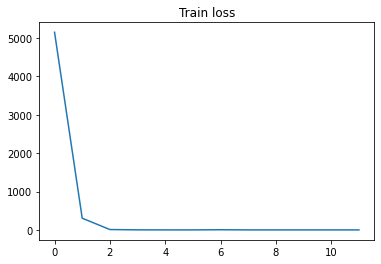

In [23]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.title('Train loss')
plt.show()

In [2]:
import torch

input_data = torch.tensor([4,3,2,0,1])
sorted, indexes = torch.sort(input_data)
print(indexes)

formatted_output = [0 for i in range(5)]
k = 0
for i in indexes:
  formatted_output[k] = int(input_data[i])
  k +=1
print(formatted_output)

tensor([3, 4, 2, 1, 0])
[0, 1, 2, 3, 4]


In [49]:
preds = predict(val_loader, pointer_modified)

softmax = nn.Softmax(dim=1)

def use_indexes_to_build_sorted_array(input_data, indexes):
  formatted_output = [0 for i in range(seq_len)]
  k = 0
  for i in indexes:
    formatted_output[k] = int(input_data[i])
    k +=1
  return formatted_output

for input_data, pred in preds:
  # print(pred)
  input_batch = []

  input_batch.append(input_data[0].numpy())
  input_batch.append(input_data[1].numpy())

  true_array_indexes = torch.zeros(batch_size, seq_len, dtype=torch.long)
  pred_array_indexes = torch.zeros(batch_size, seq_len, dtype=torch.long)

  k = 0
  for logits, true in pred:
    # print('True:')
    # print(true)

    # (batch_size is 2)
    true_array_indexes[0][k] = true[0]
    true_array_indexes[1][k] = true[1]

    # print('Predicted it must be in position: ')
    argmax_idx = torch.argmax(softmax(logits), dim=1)
    pred_array_indexes[0][k] = argmax_idx[0]
    pred_array_indexes[1][k] = argmax_idx[1]
    k += 1

  pred_array_formatted = []
  for i in range(batch_size):
    pred_array_formatted.append(use_indexes_to_build_sorted_array(input_batch[i], pred_array_indexes[i]))

  true_array_formatted = []
  for i in range(batch_size):
    true_array_formatted.append(use_indexes_to_build_sorted_array(input_batch[i], true_array_indexes[i]))

  """
  this commentted code is just to ensure that true_array_indexes is being interpreted correctly,
  which means the below true_array must be equal to true_array_indexes

  true_array = []
  for i in range(batch_size):
    true_array.append(torch.sort(input_batch[i])[1])
  print('true array')
  print(true_array)
  """

  print('-----------')
  print('input_batch')
  print(np.array(input_batch))
  print()

  print('true indexes')
  print(true_array_indexes.numpy())
  print()
  
  print('true formatted')
  print(np.array(true_array_formatted))
  print()

  print('pred indexes')
  print(pred_array_indexes.numpy())
  print()
  
  print('pred formatted')
  print(np.array(pred_array_formatted))
  print()

  break

C:\Users\Felipe\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\Felipe\AppData\Local\Temp\ipykernel_11268\1698486819.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


-----------
input_batch
[[7 2 4 9 8 1 6 5 3 0]
 [1 4 3 7 6 9 8 0 5 2]]

true indexes
[[9 5 1 8 2 7 6 0 4 3]
 [7 0 9 2 1 8 4 3 6 5]]

true formatted
[[0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]]

pred indexes
[[9 5 1 8 2 7 6 0 4 3]
 [7 0 9 2 1 8 4 3 6 5]]

pred formatted
[[0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]]

